# Inference Notebook

## Simple Imports

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

/home/rustt/miniforge3/envs/building_detection/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Generator

In [194]:
class Dataset(BaseDataset):

    
    CLASSES = ['building']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = sorted(os.listdir(images_dir))
        self.images_fps = sorted([os.path.join(images_dir, image_id) for image_id in self.ids])
        self.masks_fps = sorted([os.path.join(masks_dir, image_id) for image_id in self.ids])
        print(self.ids)
        
        # convert str names to class values on masks
        #self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in [125]]
        mask = np.stack(masks, axis=-1).astype('float')

        print(self.ids[i])
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, self.ids[i]
        
    def __len__(self):
        return len(self.ids)

## Augmentations

In [36]:
import albumentations as albu

In [227]:
def get_training_augmentation():
    train_transform = [

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),
        
        albu.IAAAffine(p=1),
                
        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
                albu.IAAAffine(p=1)
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
                albu.IAAAffine(p=1)
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
                albu.IAAAffine(p=1)
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
    albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [213]:
image.shape

(3, 384, 480)

## Define Model

In [6]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [223]:
ENCODER = 'se_resnext101_32x4d'
ENCODER = "resnet101"
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['building']
ACTIVATION = 'sigmoid'
DEVICE = 'cpu'

model = smp.UnetPlusPlus(
                encoder_name=ENCODER, 
                encoder_weights=ENCODER_WEIGHTS, 
                classes=len(CLASSES), 
                activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [196]:
# Load saved checkpoint
model_path = os.path.expanduser("~/Documents/Projects/building_damage/Parking/UnetPP_Istanbul.pth")
best_model = torch.load(model_path, map_location=torch.device('cpu')) # Path of the weights file

In [42]:
pwd

'/home/rustt/Documents/Projects/building_damage/morocco_damage_building/notebooks/exploration'

In [224]:
# Define path of the folder containing images to be predicted.
# For the sake of data generator, define y_test_dir same as x_test_dir.
# You will define prediction outpath two cells below.

root ="/home/rustt/Documents/Projects/building_damage/morocco_damage_building"
x_test_dir = os.path.join(root, "data", "tmp", "patches")
y_test_dir = os.path.join(root, "data", "tmp", "patches")

In [225]:
# Create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset, shuffle=False)

['patch_0.jpg', 'patch_1.jpg', 'patch_10.jpg', 'patch_11.jpg', 'patch_12.jpg', 'patch_13.jpg', 'patch_14.jpg', 'patch_15.jpg', 'patch_2.jpg', 'patch_3.jpg', 'patch_4.jpg', 'patch_5.jpg', 'patch_6.jpg', 'patch_7.jpg', 'patch_8.jpg', 'patch_9.jpg']


## Prediction - GeoTiff

In [45]:
os.listdir(x_test_dir)

['200_before_104001004F028F00-visual.png',
 '200_before_1040010077691A00-visual.png',
 '200_before_10400100889ABF00-visual.png',
 '200_before_104001006E42F300-visual.png',
 '200_before_1040010045AE4B00-visual.png',
 '200_before_104001006975B600-visual.png']

In [66]:
path_test = os.path.join(x_test_dir, os.listdir(x_test_dir)[0])

In [99]:
im = cv2.imread(path_test)
im.shape

(1312, 1311, 3)

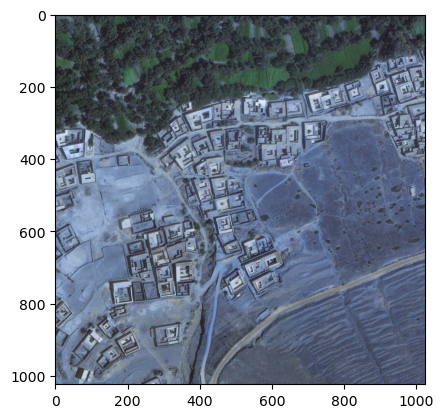

In [228]:
plt.imshow(im)

In [100]:
im = cv2.resize(im, (1024, 1024))

In [62]:
im.shape

(1024, 1024, 3)

In [68]:
from PIL import Image

In [235]:
im.shape

(1024, 1024, 3)

In [110]:
from skimage.util import view_as_blocks
path_test = os.path.join(x_test_dir, os.listdir(x_test_dir)[0])

patch_dir = os.path.join(root, "data", "tmp", "patches")

im = cv2.imread(path_test)

im = cv2.resize(im, (1024, 1024))
blocks = view_as_blocks(im, (256, 256, 3))

if not os.path.exists(patch_dir): 
    os.mkdir(patch_dir)
for i in range(blocks.shape[0]):
    for j in range(blocks.shape[1]):
        patch = blocks[i, j, 0]
        num = i * blocks.shape[1] + j
        patch = Image.fromarray(patch)
        patch.save(os.path.join(patch_dir, f"patch_{num}.jpg"))

In [193]:
prediction_images = os.listdir(x_test_dir)
prediction_images

['patch_4.jpg',
 'patch_8.jpg',
 'patch_1.jpg',
 'patch_0.jpg',
 'patch_2.jpg',
 'patch_6.jpg',
 'patch_12.jpg',
 'patch_15.jpg',
 'patch_11.jpg',
 'patch_9.jpg',
 'patch_7.jpg',
 'patch_5.jpg',
 'patch_3.jpg',
 'patch_13.jpg',
 'patch_14.jpg',
 'patch_10.jpg']

In [226]:
%%time
from skimage import io
prediction_images = os.listdir(x_test_dir)
pred_dir = os.path.join(root, "data", "tmp", "pred_2")

res = []

if not os.path.exists(pred_dir): 
    os.mkdir(pred_dir)

for i in range(len(test_dataset)):
    
    image, name = test_dataset[i]
    print(image.shape)
    
    #gt_mask = gt_mask.squeeze()
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    pr_mask = cv2.resize(pr_mask, (256, 256))
    pred = Image.fromarray(((1-pr_mask)*255).astype(np.uint8))

    pred.save(os.path.join(pred_dir, f"pred_{name.split('_')[1]}"))
    res.append((name, pred))

patch_0.jpg
(3, 384, 384)
patch_1.jpg
(3, 384, 384)
patch_10.jpg
(3, 384, 384)
patch_11.jpg
(3, 384, 384)
patch_12.jpg
(3, 384, 384)
patch_13.jpg
(3, 384, 384)
patch_14.jpg
(3, 384, 384)
patch_15.jpg
(3, 384, 384)
patch_2.jpg
(3, 384, 384)
patch_3.jpg
(3, 384, 384)
patch_4.jpg
(3, 384, 384)
patch_5.jpg
(3, 384, 384)
patch_6.jpg
(3, 384, 384)
patch_7.jpg
(3, 384, 384)
patch_8.jpg
(3, 384, 384)
patch_9.jpg
(3, 384, 384)
CPU times: user 7min 34s, sys: 59.2 s, total: 8min 33s
Wall time: 1min 42s


In [210]:
image.shape

(3, 384, 480)

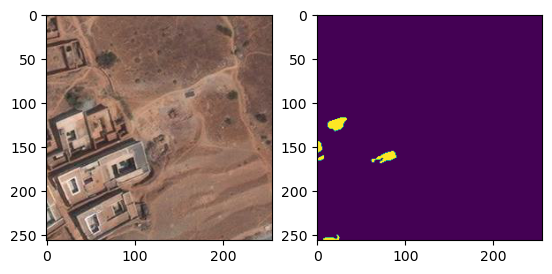

In [217]:
idx = 2
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread(os.path.join(x_test_dir, res[idx][0])))
plt.subplot(1, 2, 2)
plt.imshow(res[idx][1])


In [ ]:
    # im = tifffile.imread(image_dir)
    # width = im.shape[1]
    # height = im.shape[0]
    # ds = gdal.Open(image_dir)
    # tfw = ds.GetGeoTransform()
    # prj = ds.GetProjection()
    # srs = osr.SpatialReference(wkt=prj)
    # driver = gdal.GetDriverByName("GTiff")
    
    # outdata = driver.Create(out_path, height, width, 1, gdal.GDT_Byte)
    # outdata.SetGeoTransform(tfw)##sets same geotransform as input
    # outdata.SetProjection(ds.GetProjection())##sets same projection as input
    # outdata.GetRasterBand(1).WriteArray(pr_mask)
    # outdata.FlushCache() ##saves to disk!!
    # outdata = None
    # ds=None